In [32]:
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [33]:
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [34]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [35]:
content_image = load_image('./Images/color/53.jpg')
style_image = load_image('./Images/styled/style_image1.png')

In [36]:
content_image.shape

TensorShape([1, 150, 150, 3])

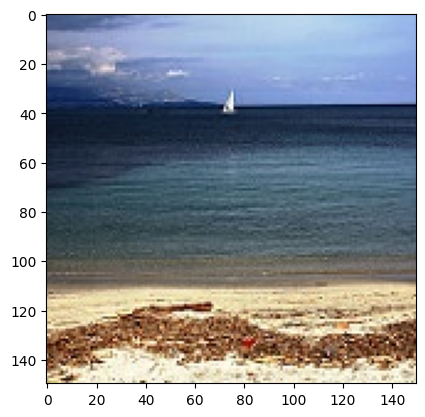

In [37]:
plt.imshow(np.squeeze(content_image))
plt.show()

In [38]:
style_image.shape

TensorShape([1, 599, 757, 3])

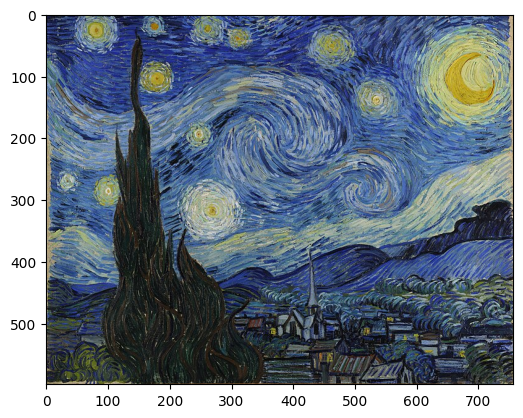

In [39]:
plt.imshow(np.squeeze(style_image))
plt.show()

In [40]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]

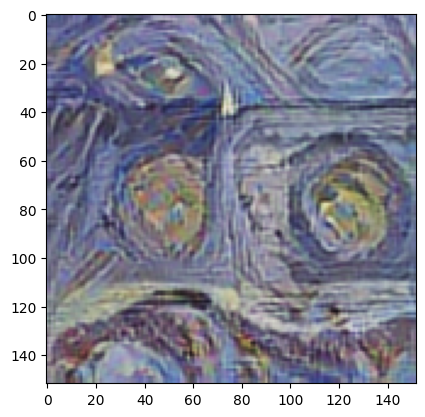

In [41]:
plt.imshow(np.squeeze(stylized_image))
plt.show()

In [11]:
cv2.imwrite('generated_img.jpg', cv2.cvtColor(np.squeeze(stylized_image)*255, cv2.COLOR_BGR2RGB))

True

You can even change the content images and style images according to your likes and download the stylised image from the outputs sections after running the whole script. Thank you!!

In [1]:
from PIL import Image
import os

# Đường dẫn đến hình ảnh gốc
image_path = "./Images/styled/modernArt.webp"

# Thư mục để lưu các bản sao
save_dir = "./Images/styleTransfer/modernArtTrain/"

# Tạo thư mục nếu chưa tồn tại
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Số lượng bản sao bạn muốn tạo
num_copies = 1500

# Tải hình ảnh
original_image = Image.open(image_path)

# Tạo và lưu các bản sao
for i in range(num_copies):
    # Tạo tên tệp cho bản sao
    copy_name = f"copy_{i + 1}.jpg"
    copy_path = os.path.join(save_dir, copy_name)

    # Lưu bản sao
    original_image.save(copy_path)

    print(f"Lưu thành công: {copy_path}")


Lưu thành công: ./Images/modernArtTrain/copy_1.jpg
Lưu thành công: ./Images/modernArtTrain/copy_2.jpg
Lưu thành công: ./Images/modernArtTrain/copy_3.jpg
Lưu thành công: ./Images/modernArtTrain/copy_4.jpg
Lưu thành công: ./Images/modernArtTrain/copy_5.jpg
Lưu thành công: ./Images/modernArtTrain/copy_6.jpg
Lưu thành công: ./Images/modernArtTrain/copy_7.jpg
Lưu thành công: ./Images/modernArtTrain/copy_8.jpg
Lưu thành công: ./Images/modernArtTrain/copy_9.jpg
Lưu thành công: ./Images/modernArtTrain/copy_10.jpg
Lưu thành công: ./Images/modernArtTrain/copy_11.jpg
Lưu thành công: ./Images/modernArtTrain/copy_12.jpg
Lưu thành công: ./Images/modernArtTrain/copy_13.jpg
Lưu thành công: ./Images/modernArtTrain/copy_14.jpg
Lưu thành công: ./Images/modernArtTrain/copy_15.jpg
Lưu thành công: ./Images/modernArtTrain/copy_16.jpg
Lưu thành công: ./Images/modernArtTrain/copy_17.jpg
Lưu thành công: ./Images/modernArtTrain/copy_18.jpg
Lưu thành công: ./Images/modernArtTrain/copy_19.jpg
Lưu thành công: ./Ima

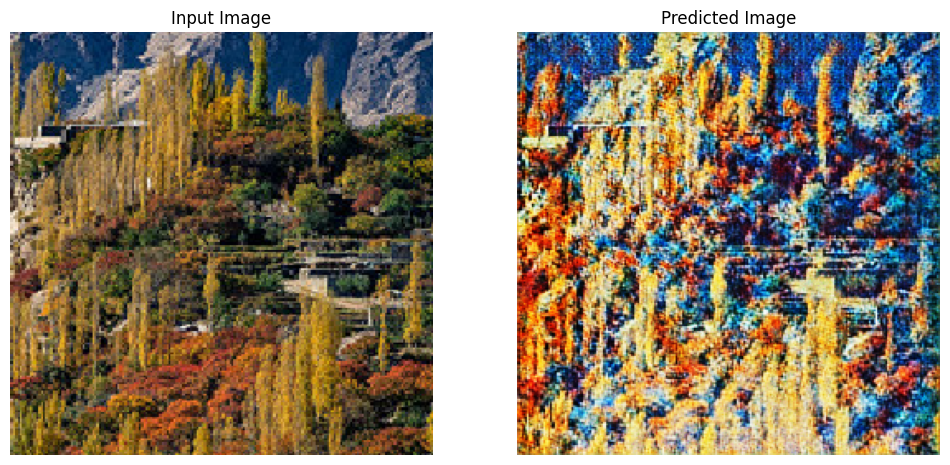

Lưu checkpoint cho epoch 1 tại ./styleTransferCheckpoints/modernArtTrain\ckpt-1
Thời gian cho epoch 1 là 13809.990463256836 giây

.....................................

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Ẩn tất cả các cảnh báo của TensorFlow
tf.get_logger().setLevel('ERROR')  # Ẩn cảnh báo từ logger của TensorFlow

# Kiểm tra và cấu hình GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)  # Cho phép tăng trưởng bộ nhớ
    except RuntimeError as e:
        print(e)

AUTOTUNE = tf.data.AUTOTUNE

# folder path for dataset
folder_path = "./Images/styleTransfer/"
style_path = "./Images/styleTransfer/modernArtTrain"
photos_path = "./Images/styleTransfer/normalPhotoTrain"

#Model Parameters
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

l = ['style_jpg', 'photo_jpg'] # there are two types od image in dataset

# reading train  data from directory and leabeling them
train_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=BATCH_SIZE)

# Reading test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=BATCH_SIZE)

#class names
class_names = train_ds.class_names
class_names

#Separating  styles and photos in dataset
def parse(image, label):
    return image, label

#get style image
def filter_style(image, label):
  
    return tf.equal(label[0], 0)


#get photo image
def filter_photo(image, label):
    return tf.equal(label[0], 1)

#style
style_train= train_ds.map(parse).filter(filter_style)
style_test = test_ds.map(parse).filter(filter_style)

#photo
photo_train= train_ds.map(parse).filter(filter_photo)
photo_test = test_ds.map(parse).filter(filter_photo)

#Preprocessing funcitons

#1 crop
def random_crop(image):

  cropped_image = tf.image.random_crop(
      image, size=[256, 256, 3], seed = None, name = None)

  return cropped_image


#2 normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

#3 random jitters
def random_jitter(image):
  # resizing to 360 x 360 x 3
  image = tf.image.resize(image, [360, 360],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  image = tf.squeeze(image) # Remove the "None" dimension
  

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

# train dataset will be normalized and have random jitters
def preprocess_image_train(image, label):
  
  image = random_jitter(image)
  image = normalize(image)

  return image

# test dataset will only have normalized data
def preprocess_image_test(image, label):
  image = normalize(image)
  image = tf.squeeze(image)
  return image

style_train = style_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_train = photo_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

style_test= style_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_test = photo_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

sample_style = next(iter(style_train))
sample_photo = next(iter(photo_train))

OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

# Constants and loss functions
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoint and manager setup
checkpoint_path = "./styleTransferCheckpoints/modernArtTrain"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Restore the latest checkpoint if it exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
    print('Latest checkpoint restored!!')

# Function to generate images
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# Training step function
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

EPOCHS = 5

# Vòng lặp huấn luyện
step_count = 0  # Biến đếm bước
for epoch in range(EPOCHS):
    start_time = time.time()  # Bắt đầu đo thời gian
    n = 0

    # Kết hợp hai tập dữ liệu
    for image_x, image_y in tf.data.Dataset.zip((photo_train, style_train)):
        train_step(image_x, image_y)  # Thực hiện bước huấn luyện
        step_count += 1

        if n % 1 == 0:  # In dấu chấm mỗi bước
            print('.', end='')

        n += 1

    # Thực hiện các thao tác khác sau khi hoàn thành vòng lặp
    clear_output(wait=True)  # Xóa output cũ
    generate_images(generator_g, sample_photo)  # Tạo hình ảnh mới

    # Lưu checkpoint sau mỗi epoch
    ckpt_save_path = ckpt_manager.save()
    print('Lưu checkpoint cho epoch {} tại {}'.format(epoch + 1, ckpt_save_path))

    print('Thời gian cho epoch {} là {} giây\n'.format(epoch + 1, time.time() - start_time))

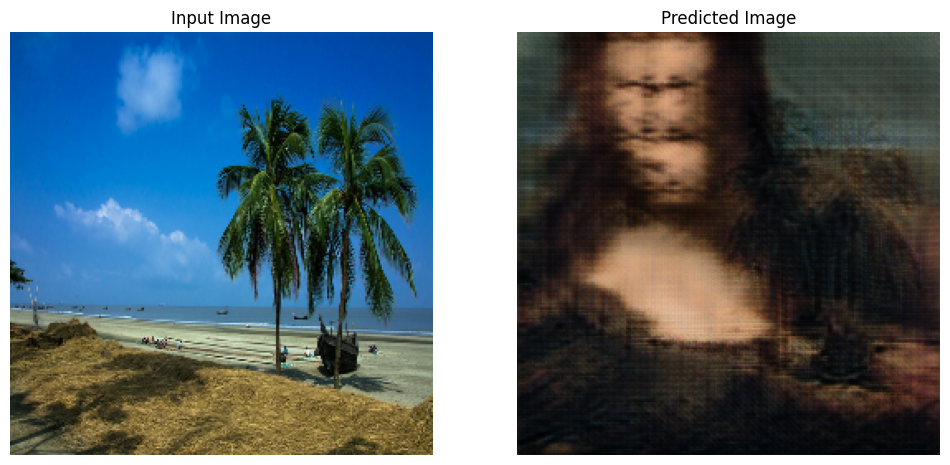

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # Allow dynamic GPU memory allocation

tf.get_logger().setLevel('ERROR')  # Suppress logging

# Checkpoint path
checkpoint_path = "./styleTransferCheckpoints/modernArtTrain"

# Create generators
OUTPUT_CHANNELS = 3
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# Create checkpoint and manager
ckpt = tf.train.Checkpoint(generator_g=generator_g, generator_f=generator_f)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

specific_checkpoint_path = "./styleTransferCheckpoints/modernArtTrain/ckpt-4"  

# Restore the specific checkpoint
ckpt.restore(specific_checkpoint_path).expect_partial()

# Function to convert images
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5) + 0.5)  # Rescale back to [0, 1]
        plt.axis('off')
    plt.show()

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Read JPG image
    original_size = tf.shape(image)[:2]  # Get original size (height, width)

    # Resize only if necessary; if your model can handle this size, keep it.
    if original_size[0] != 256 or original_size[1] != 256:
        image = tf.image.resize(image, [256, 256])  # Resize for model if needed
    
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image, original_size

# Input image path
input_image_path = './Images/styleTransfer/normalPhotoTrain/120.jpg'

# Load and prepare the image
input_image, original_size = load_and_preprocess_image(input_image_path)
input_image = tf.expand_dims(input_image, 0)  # Add batch dimension

# Convert and resize image
generate_images(generator_g, input_image)
